## MODELOS DE LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [2]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Se grafica la data "original" de Demanda en sector eléctrico

Text(0, 0.5, 'Demanda [MMpcd]')

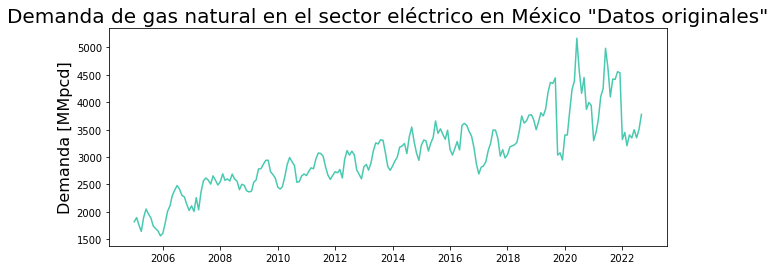

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

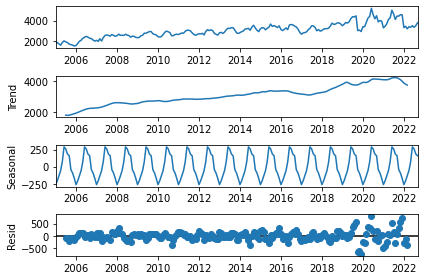

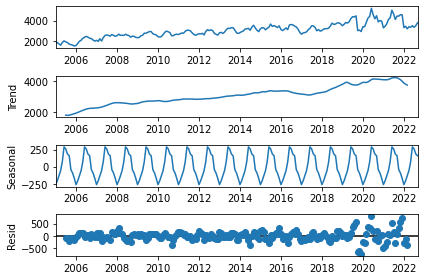

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se grafica la distribución de la data "original" de TRAIN de Demanda en sector eléctrico

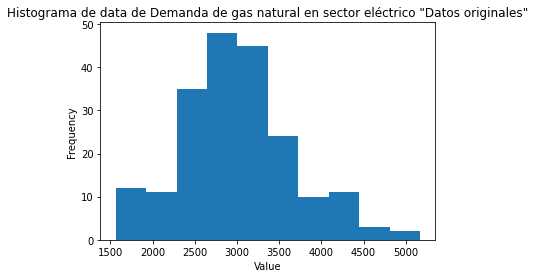

In [6]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos originales de TRAIN de Demanda en sector eléctrico

In [7]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_data.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.449201490304391
p-value: 0.024122729621181227


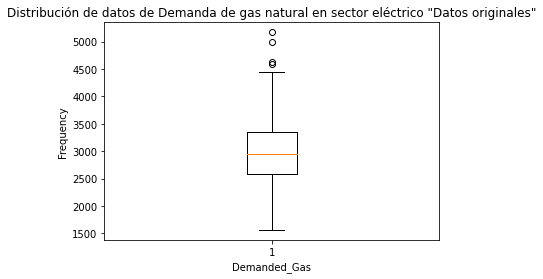

In [8]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
n_input = 24

data = demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data 

demanda_electrico_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [11]:
demanda_electrico_original_train_generator[0]

(array([[1819.58, 1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05,
         1889.66, 1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33,
         2006.88, 2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49,
         2273.91, 2134.41, 2025.98]]),
 array([2108.85]))

In [12]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [13]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [15]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_sin_tratamiento = Sequential()
model_LSTM_electrico_sin_tratamiento.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_sin_tratamiento.add(Dense(1))
model_LSTM_electrico_sin_tratamiento.compile(optimizer='adam', loss='mse')

In [16]:
model_LSTM_electrico_sin_tratamiento.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo LSTM

In [17]:
model_LSTM_electrico_sin_tratamiento.fit(demanda_electrico_original_train_generator, epochs=15)


Epoch 1/15
177/177 [==============================] - 3s 8ms/step - loss: 3739876.5000
Epoch 2/15
177/177 [==============================] - 1s 8ms/step - loss: 1948205.8750
Epoch 3/15
177/177 [==============================] - 1s 8ms/step - loss: 332191.5938
Epoch 4/15
177/177 [==============================] - 1s 8ms/step - loss: 355189.5938
Epoch 5/15
177/177 [==============================] - 1s 8ms/step - loss: 1523940.3750
Epoch 6/15
177/177 [==============================] - 2s 8ms/step - loss: 210897.8281
Epoch 7/15
177/177 [==============================] - 2s 8ms/step - loss: 141886.5156
Epoch 8/15
177/177 [==============================] - 2s 9ms/step - loss: 133207.5000
Epoch 9/15
177/177 [==============================] - 1s 8ms/step - loss: 133847.0469
Epoch 10/15
177/177 [==============================] - 1s 8ms/step - loss: 114268.0469
Epoch 11/15
177/177 [==============================] - 2s 8ms/step - loss: 164210.2656
Epoch 12/15
177/177 [============================

Se grafica la perdida por epoch

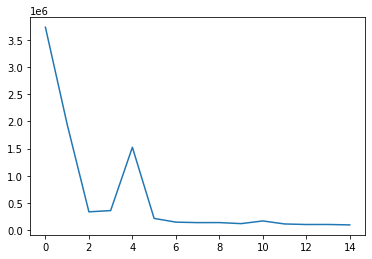

In [18]:
loss_per_epoch_model_FF = model_LSTM_electrico_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [19]:
data = demanda_electrico_original_train_data['Demanded_Gas'].values

demanda_electrico_train_batch_sin_tratamiento = data[-n_input:]

demanda_electrico_train_batch_sin_tratamiento

array([3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 , 4235.25,
       4387.91, 5168.27, 4581.99, 4163.77, 4451.61, 3869.77, 3996.14,
       3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93, 4985.53,
       4631.85, 4098.81, 4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [20]:
demanda_electrico_train_batch_sin_tratamiento_reshaped = demanda_electrico_train_batch_sin_tratamiento.reshape(1,n_input, n_features)
demanda_electrico_train_batch_sin_tratamiento_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [21]:
model_LSTM_electrico_sin_tratamiento.predict(demanda_electrico_train_batch_sin_tratamiento_reshaped)

1/1 [==============================] - 0s 238ms/step


array([[3938.2505]], dtype=float32)

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [22]:
demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [23]:
n_input = 24
n_features = 1

In [24]:
test_predictions_model_LSTM_electrico_sin_pretratamiento = []

first_eval_batch = demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_sin_tratamiento.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 26ms/step


In [25]:
test_predictions_model_LSTM_electrico_sin_pretratamiento

[array([3938.2505], dtype=float32),
 array([4097.1816], dtype=float32),
 array([4161.0854], dtype=float32),
 array([4301.6963], dtype=float32),
 array([4496.5864], dtype=float32),
 array([4605.743], dtype=float32),
 array([4687.029], dtype=float32),
 array([4723.3154], dtype=float32),
 array([4792.1064], dtype=float32),
 array([4717.468], dtype=float32),
 array([4596.0347], dtype=float32),
 array([4491.2256], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM sin la data pretratada

Text(0, 0.5, 'Demanda [MMpcd]')

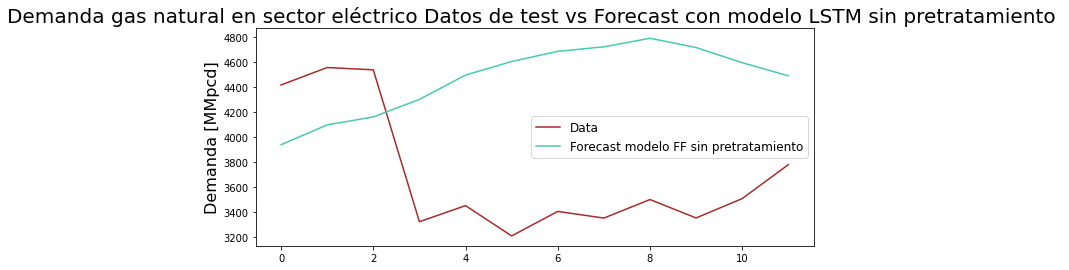

In [26]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_sin_pretratamiento, color='#48C9B0')
plt.legend(('Data', 'Forecast modelo FF sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM sin pretratamiento ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [27]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_electrico_sin_pretratamiento = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_sin_pretratamiento)
RMSE_predictions_model_LSTM_electrico_sin_pretratamiento= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_sin_pretratamiento))

print('MAPE:', MAPE_predictions_model_LSTM_electrico_sin_pretratamiento)
print('RMSE:', RMSE_predictions_model_LSTM_electrico_sin_pretratamiento)

MAPE: 0.28263944818122805
RMSE: 1055.4601908437328


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [28]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [29]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [31]:
demanda_electrico_original_train_para_tratamiento =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [32]:
demanda_electrico_train_pretratamiento_media = remove_replace_outliers_media(demanda_electrico_original_train_para_tratamiento['Demanded_Gas'])
demanda_electrico_train_pretratamiento_media

Date
2005-01-01    1819.580000
2005-02-01    1895.330000
2005-03-01    1765.860000
2005-04-01    2944.216952
2005-05-01    1895.540000
                 ...     
2021-05-01    4243.930000
2021-06-01    2944.216952
2021-07-01    2944.216952
2021-08-01    4098.810000
2021-09-01    2944.216952
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

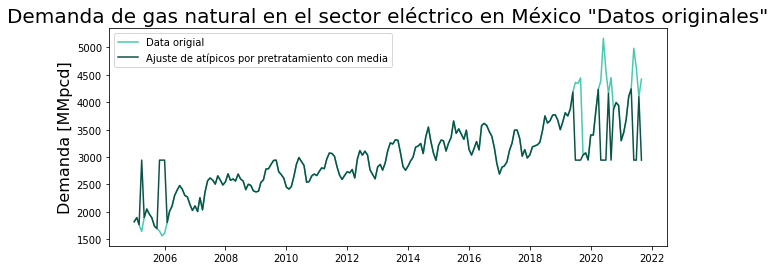

In [33]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de media artimetica de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

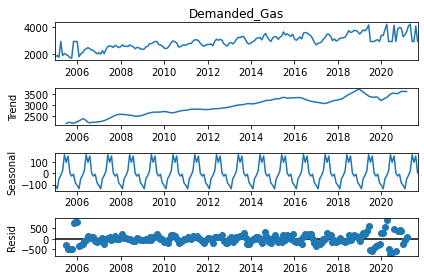

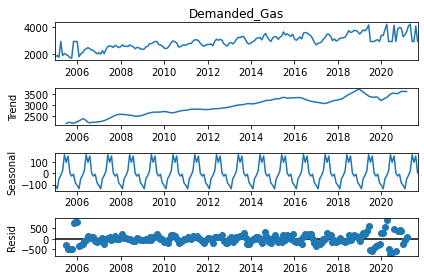

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_media_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_media)
demanda_electrico_train_pretratamiento_media_seasonal_decomposition.plot()

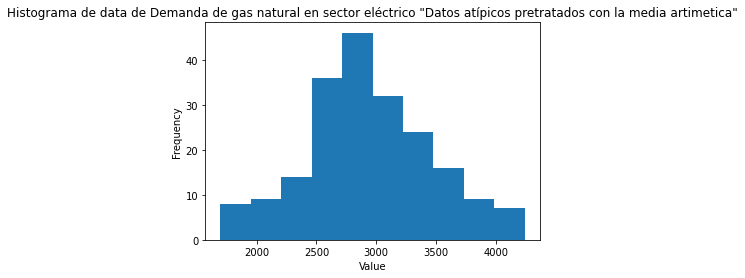

In [35]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [36]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.11247875673965152
p-value: 0.9453128213619225


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

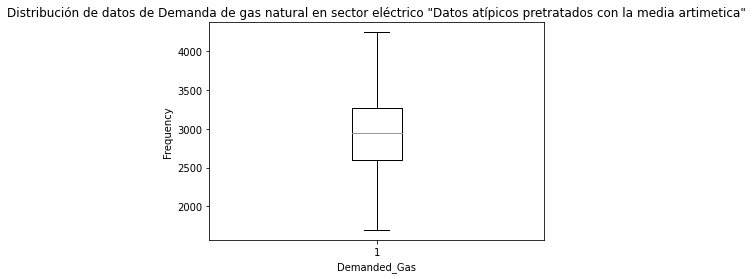

In [37]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [38]:
n_input = 24

data = demanda_electrico_train_pretratamiento_media
targets = data 

demanda_electrico_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [39]:
demanda_electrico_train_generator_pretratamiento_media[0]

(array([[1819.58      , 1895.33      , 1765.86      , 2944.21695187,
         1895.54      , 2051.72      , 1962.05      , 1889.66      ,
         1739.1       , 1695.92      , 2944.21695187, 2944.21695187,
         2944.21695187, 1806.33      , 2006.88      , 2108.31      ,
         2298.9       , 2398.88      , 2480.62      , 2413.08      ,
         2298.49      , 2273.91      , 2134.41      , 2025.98      ]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [41]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU.  

In [43]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [44]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretratamiento_media = Sequential()
model_LSTM_electrico_pretratamiento_media.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_media.add(Dense(1))
model_LSTM_electrico_pretratamiento_media.compile(optimizer='adam', loss='mse')

In [45]:
model_LSTM_electrico_pretratamiento_media.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [47]:
model_LSTM_electrico_pretratamiento_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=25)

Epoch 1/25
  7/177 [>.............................] - ETA: 1s - loss: 86550.8516

177/177 [==============================] - 1s 8ms/step - loss: 104628.6875
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 99125.3672
Epoch 3/25
177/177 [==============================] - 1s 8ms/step - loss: 106441.0312
Epoch 4/25
177/177 [==============================] - 1s 8ms/step - loss: 119969.1328
Epoch 5/25
177/177 [==============================] - 2s 8ms/step - loss: 106172.4531
Epoch 6/25
177/177 [==============================] - 2s 9ms/step - loss: 102183.7656
Epoch 7/25
177/177 [==============================] - 2s 8ms/step - loss: 108848.6406
Epoch 8/25
177/177 [==============================] - 1s 8ms/step - loss: 106921.7734
Epoch 9/25
177/177 [==============================] - 2s 8ms/step - loss: 106195.8203
Epoch 10/25
177/177 [==============================] - 1s 8ms/step - loss: 100866.9844
Epoch 11/25
177/177 [==============================] - 2s 8ms/step - loss: 112747.0859
Epoch 12/25
177/177 [==============================] - 1s 7ms/st

Se grafica la perdida por epoch 

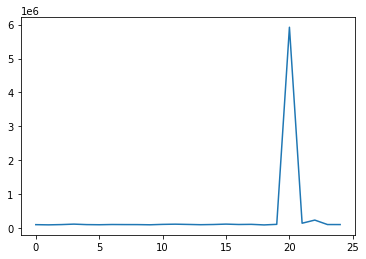

In [48]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [49]:
demanda_electrico_train_batch_pretratamiento_media = demanda_electrico_train_pretratamiento_media.values[-n_input:]


demanda_electrico_train_batch_pretratamiento_media

array([3037.44      , 3076.62      , 2947.09      , 3402.47      ,
       3402.47      , 3819.3       , 4235.25      , 2944.21695187,
       2944.21695187, 2944.21695187, 4163.77      , 2944.21695187,
       3869.77      , 3996.14      , 3941.12      , 3298.43      ,
       3454.21      , 3681.3       , 4104.82      , 4243.93      ,
       2944.21695187, 2944.21695187, 4098.81      , 2944.21695187])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [50]:
demanda_electrico_train_batch_pretratamiento_media_reshaped = demanda_electrico_train_batch_pretratamiento_media.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_reshaped

array([[[3037.44      ],
        [3076.62      ],
        [2947.09      ],
        [3402.47      ],
        [3402.47      ],
        [3819.3       ],
        [4235.25      ],
        [2944.21695187],
        [2944.21695187],
        [2944.21695187],
        [4163.77      ],
        [2944.21695187],
        [3869.77      ],
        [3996.14      ],
        [3941.12      ],
        [3298.43      ],
        [3454.21      ],
        [3681.3       ],
        [4104.82      ],
        [4243.93      ],
        [2944.21695187],
        [2944.21695187],
        [4098.81      ],
        [2944.21695187]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [51]:
model_LSTM_electrico_pretratamiento_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)

1/1 [==============================] - 0s 246ms/step


array([[3605.15]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [52]:
n_input = 24
n_features = 1

In [54]:
test_predictions_model_LSTM_electrico_pretratamiento_media  = []

first_eval_batch = demanda_electrico_train_pretratamiento_media.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 27ms/step


In [55]:
test_predictions_model_LSTM_electrico_pretratamiento_media

[array([3605.15], dtype=float32),
 array([3582.1667], dtype=float32),
 array([3635.122], dtype=float32),
 array([3568.1323], dtype=float32),
 array([3659.6619], dtype=float32),
 array([3744.495], dtype=float32),
 array([3648.3843], dtype=float32),
 array([3581.7458], dtype=float32),
 array([3773.3613], dtype=float32),
 array([3724.0637], dtype=float32),
 array([3646.509], dtype=float32),
 array([3722.545], dtype=float32)]

In [56]:
demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

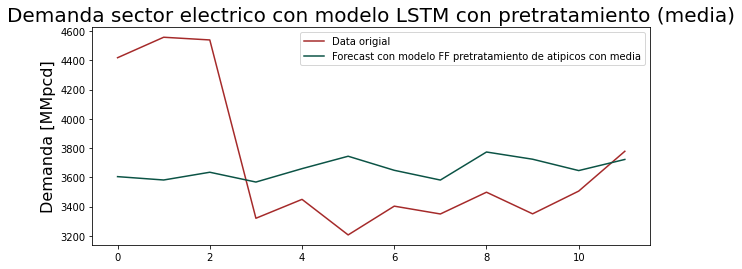

In [57]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#0B5345')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo FF pretratamiento de atipicos con media'))

plt.title('Demanda sector electrico con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [58]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media)

MAPE: 0.10713716575270187
RMSE: 514.2130214225829


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

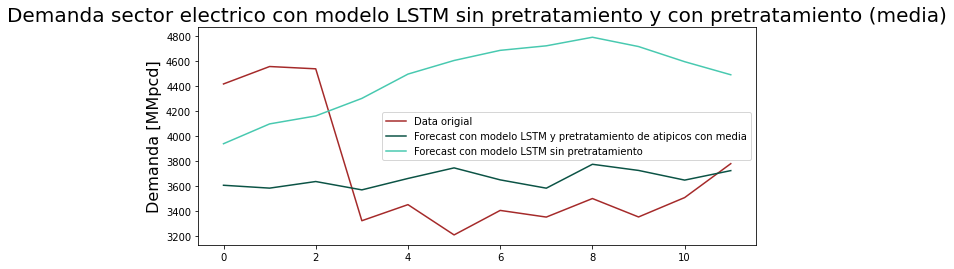

In [59]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#0B5345')
plt.plot(test_predictions_model_LSTM_electrico_sin_pretratamiento, color='#48C9B0')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [61]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [62]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [63]:
demanda_electrico_original_train_para_tratamiento2 = demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [64]:
demanda_electrico_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_electrico_original_train_para_tratamiento2['Demanded_Gas'])
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    2939.05
2005-05-01    1895.54
               ...   
2021-05-01    4243.93
2021-06-01    2939.05
2021-07-01    2939.05
2021-08-01    4098.81
2021-09-01    2939.05
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

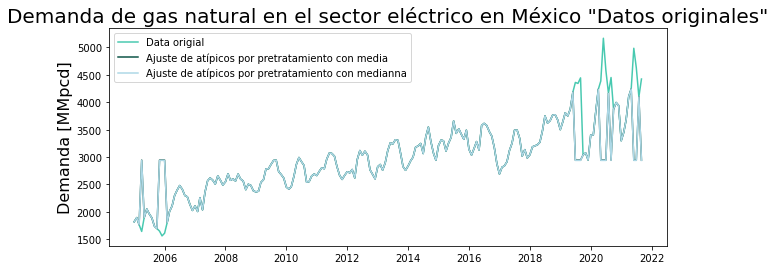

In [65]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_electrico_train_pretratamiento_mediana, color= 'lightblue')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con medianna'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

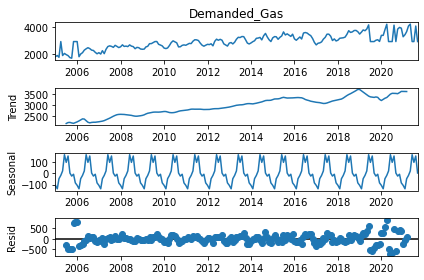

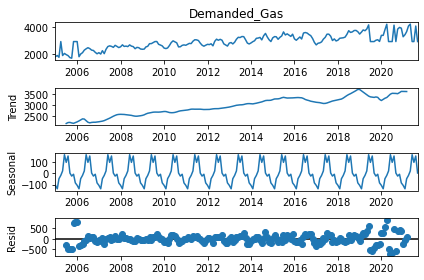

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_mediana)
demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition.plot()


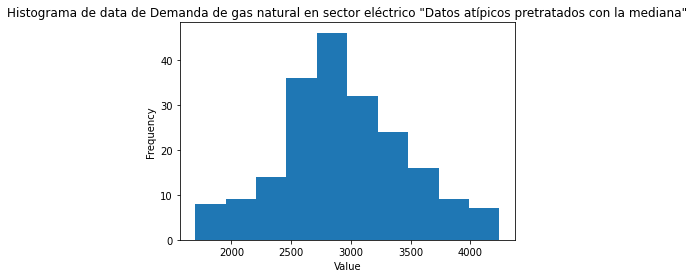

In [67]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [68]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.12060749433842288
p-value: 0.9414785187134115


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [69]:
n_input = 24

data = demanda_electrico_train_pretratamiento_mediana
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana[0]

(array([[1819.58, 1895.33, 1765.86, 2939.05, 1895.54, 2051.72, 1962.05,
         1889.66, 1739.1 , 1695.92, 2939.05, 2939.05, 2939.05, 1806.33,
         2006.88, 2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49,
         2273.91, 2134.41, 2025.98]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [70]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [76]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [77]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretratamiento_mediana = Sequential()

model_LSTM_electrico_pretratamiento_mediana.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_mediana.add(Dense(1))
model_LSTM_electrico_pretratamiento_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_electrico_pretratamiento_mediana.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo 

In [78]:
model_LSTM_electrico_pretratamiento_mediana.fit(demanda_electrico_train_generator_pretratamiento_mediana, epochs=25)

Epoch 1/25


177/177 [==============================] - 3s 8ms/step - loss: 6150539.5000
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 3962936.0000
Epoch 3/25
177/177 [==============================] - 2s 9ms/step - loss: 180600.5469
Epoch 4/25
177/177 [==============================] - 1s 8ms/step - loss: 551758.1875
Epoch 5/25
177/177 [==============================] - 1s 8ms/step - loss: 113916.4062
Epoch 6/25
177/177 [==============================] - 1s 8ms/step - loss: 103147.7188
Epoch 7/25
177/177 [==============================] - 1s 8ms/step - loss: 99397.4375
Epoch 8/25
177/177 [==============================] - 1s 8ms/step - loss: 93432.2422
Epoch 9/25
177/177 [==============================] - 1s 8ms/step - loss: 122066.8672
Epoch 10/25
177/177 [==============================] - 2s 8ms/step - loss: 246630.6875
Epoch 11/25
177/177 [==============================] - 1s 7ms/step - loss: 103413.0078
Epoch 12/25
177/177 [==============================] - 1s 7ms/s

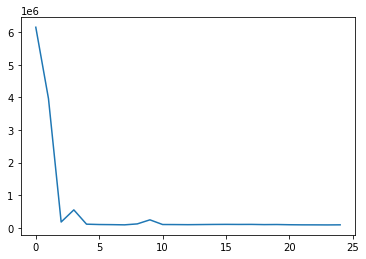

In [79]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [80]:
demanda_electrico_train_batch_pretratamiento_mediana = demanda_electrico_train_pretratamiento_mediana.values[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana

array([3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 , 4235.25,
       2939.05, 2939.05, 2939.05, 4163.77, 2939.05, 3869.77, 3996.14,
       3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93, 2939.05,
       2939.05, 4098.81, 2939.05])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [81]:
demanda_electrico_train_batch_pretratamiento_mediana_reshaped = demanda_electrico_train_batch_pretratamiento_mediana.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [2939.05],
        [2939.05],
        [2939.05],
        [4163.77],
        [2939.05],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [2939.05],
        [2939.05],
        [4098.81],
        [2939.05]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [82]:
model_LSTM_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)

1/1 [==============================] - 0s 196ms/step


array([[3524.23]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [83]:
n_input = 24
n_features = 1

In [84]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana  = []

first_eval_batch = demanda_electrico_train_pretratamiento_mediana.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


In [85]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana

[array([3524.23], dtype=float32),
 array([3563.616], dtype=float32),
 array([3699.2861], dtype=float32),
 array([3770.6335], dtype=float32),
 array([3745.5625], dtype=float32),
 array([3726.0396], dtype=float32),
 array([3757.6035], dtype=float32),
 array([3677.276], dtype=float32),
 array([3612.1], dtype=float32),
 array([3812.9148], dtype=float32),
 array([3965.0146], dtype=float32),
 array([3759.6543], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

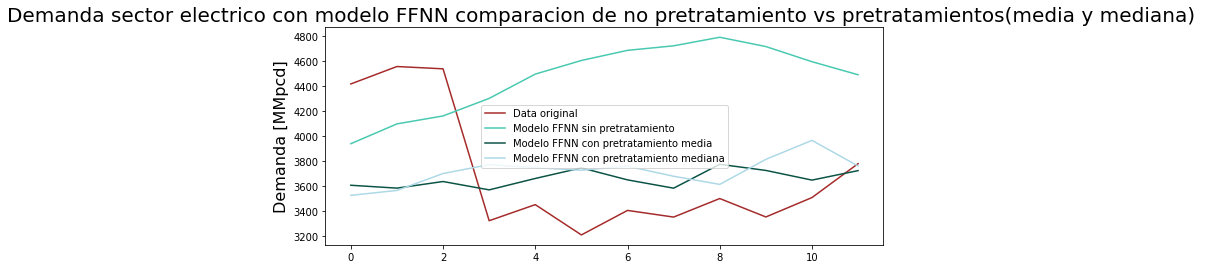

In [86]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_sin_pretratamiento, color='#48C9B0')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#0B5345')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana , color='lightblue')
plt.legend(('Data original', 'Modelo FFNN sin pretratamiento', 'Modelo FFNN con pretratamiento media', 'Modelo FFNN con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector electrico con modelo FFNN comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [87]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana )
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana ))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)

MAPE: 0.12467230178541294
RMSE: 556.7134853268764
